# 3. EEU, Expected Energy Unserved




#  Import data




In [1]:
pip --version

pip 20.0.2 from /opt/conda/lib/python3.7/site-packages/pip (python 3.7)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install psrmodels==1.2.7

Processing /home/jovyan/.cache/pip/wheels/f9/79/60/e0c7a9fc4aceccc24c614720453a189f10c908a840ab91839b/psrmodels-1.2.7-cp37-cp37m-linux_x86_64.whl
  Using cached pymc3-3.7-py3-none-any.whl (856 kB)
  Using cached Shapely-1.7.1-cp37-cp37m-manylinux1_x86_64.whl (1.0 MB)
Processing /home/jovyan/.cache/pip/wheels/26/68/6f/745330367ce7822fe0cd863712858151f5723a0a5e322cc144/Theano-1.0.5-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install Deprecated

  Using cached Deprecated-1.2.12-py2.py3-none-any.whl (9.5 kB)
Processing /home/jovyan/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6/wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl
Note: you may need to restart the kernel to use updated packages.


In [4]:
######   read data as a whole year
import numpy as np

ListofCap=[]
ListofAva=[]

text_file = open("GB_anonymised_conv.txt", "r")
# text_file = open("I_conv.txt", "r")

for line in text_file:
    if (len(line.split())>=3):
        ListofCap.append(float(line.split()[1]))
        ListofAva.append(float(line.split()[2]))

ListofCap=np.array(ListofCap)
ListofAva=np.array(ListofAva)
        

GBdem=[]
GBwind=[]
Idem=[]
Iwind=[]
# GBdem=np.array([[28372.7202573247,28372.7202573247]])
# GBwind=np.array([[700.875,700.875]])

######   read data
text_file = open("InterconnectionData_Rescaled.txt", "r")

for line in text_file:
#    if (str(line.split()[1]).startswith('"2008')):
    if (len(line.split())>=7):
        GBdem.append(float(line.split()[3]))
        GBwind.append(float(line.split()[5]))
        Idem.append(float(line.split()[4]))
        Iwind.append(float(line.split()[6]))

GBdem=np.array(GBdem)
GBwind=np.array(GBwind)
Idem=np.array(Idem)
Iwind=np.array(Iwind)
print(GBdem)
print(Idem)
#print(ListofCap)

[28372.72025732 27053.93985423 25711.9838577  ... 34494.52422018
 31811.47559633 29294.59027523]
[4759.07755373 4366.75539076 4083.8786473  ... 5663.71140072 5230.62609173
 4985.38775341]


In [5]:
#combine two area demand; and demand seperate year
demand_twoarea=np.concatenate((GBdem.reshape(7*3360,1), Idem.reshape(7*3360,1)), axis=1)
wind_twoarea=np.concatenate((GBwind.reshape(7*3360,1), Iwind.reshape(7*3360,1)), axis=1)

demand_sepyear=demand_twoarea.reshape(7,3360,2)
wind_sepyear=wind_twoarea.reshape(7,3360,2)

# print(demand_twoarea)
# print(demand_sepyear[0])

In [6]:
##check the value of LOLE
import numpy as np
import pandas as pd

from psrmodels.time_collapsed import BivariateHindcastMargin as tc_model
from psrmodels.time_collapsed import ConvGenDistribution as tc_convgen

from psrmodels.time_dependent import BivariateHindcastMargin as td_model
from psrmodels.time_dependent import ConvGenDistribution as td_convgen

gens =  pd.DataFrame({"Capacity": ListofCap, "Availability": ListofAva})

convgen_dists = [tc_convgen(gens),tc_convgen(gens)]

# create time-collapsed bivariate hindcast model

model1 = tc_model(demand=demand_twoarea,renewables=wind_twoarea,gen_dists=convgen_dists)

## compute LOLE for area 1 under a 'veto' policy an 1000MW interconnection capacity
lole=model1.lole(c=0,policy="veto",axis=0)
print(lole)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


20.983868847471033


# Simulate data




In [7]:
import numpy as np
import pandas as pd

from psrmodels.time_collapsed import BivariateHindcastMargin as tc_model
from psrmodels.time_collapsed import ConvGenDistribution as tc_convgen

from psrmodels.time_dependent import BivariateHindcastMargin as td_model
from psrmodels.time_dependent import ConvGenDistribution as td_convgen

# create toy demand and wind data with 100 observations
np.random.seed(1)

# create toy generator data

gens =  pd.DataFrame({"Capacity": ListofCap, "Availability": ListofAva})

convgen_dists = [tc_convgen(gens),tc_convgen(gens)]

# now, create a time-sequential model

# first, create time-sequential generators. We need to add a 'TTR' (time to repair) column to our generator data
gens["TTR"] = 50 #50 hours to repair on average
td_convgen_dists = [td_convgen(gens),td_convgen(gens)]


# a. Simulate data for OVERALL 7 years


In [8]:
# Simulate all year data

model2 = td_model(demand=demand_twoarea,renewables=wind_twoarea,gen_dists=td_convgen_dists)
n_sim=1000
sim_data = model2.simulate_post_itc(n_sim=n_sim,c=0,policy="veto")

In [9]:
# Simulate One year data EFC:
EFC=2755
EFCdem=demand_twoarea-EFC
EFCwind=np.zeros(shape=EFCdem.shape)

model2 = td_model(demand=EFCdem,renewables=EFCwind,gen_dists=td_convgen_dists)

#use 1000,2000,3000,5000,10000
n_sim=1000
sim_data_EFC = model2.simulate_post_itc(n_sim=n_sim,c=0,policy="veto")

# a. EU distribution for Overall 7 years


In [10]:
EU=[0]*n_sim*7
for i in range(n_sim*7):
    tempEU=0
    for j in range(3360):
        tempEU+= -min(0,sim_data[3360*i+j][0])
    EU[i]=tempEU

EUdis=sorted(EU)
#print(EUdis)

In [11]:
# EUdis_EFC using EFC
EU_EFC=[0]*n_sim*7
for i in range(n_sim*7):
    tempEU=0
    for j in range(3360):
        tempEU+= -min(0,sim_data_EFC[3360*i+j][0])
    EU_EFC[i]=tempEU


EUdis_EFC=sorted(EU_EFC)

# Calculate EFC using EEU




In [12]:
###Calculate EEU which is the average EU 
EEU=np.sum(EUdis)/len(EUdis)

print('EEU OVERALL is: ',EEU)

EEU OVERALL is:  3342.001171206211


In [13]:
EEU_EFC=np.sum(EU_EFC)/len(EU_EFC)
print('EEU (using EFC',EFC,') is', EEU_EFC)

EEU (using EFC 2755 ) is 3521.813103100166


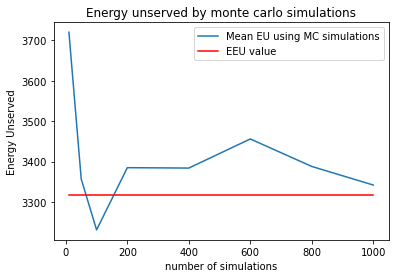

In [14]:
#plot the mean EU in a year using different number of simulations.

import matplotlib.pyplot as plt
numofsim=[10,50,100,200,400,600,800,1000]
EEUmean_mc=[3720,3357,3231,3385,3384,3456,3388,3342]
EEUmean_real=[3316.2]*8


plt.plot(numofsim,EEUmean_mc,label='Mean EU using MC simulations')
plt.plot(numofsim,EEUmean_real,"r",label='EEU value')
plt.title('Energy unserved by monte carlo simulations')
plt.xlabel('number of simulations')
plt.ylabel('Energy Unserved')
plt.legend()
plt.show()

# Calculate EFC using the probability of no shortfall




In [15]:
ProbofnoEU=0
for i in range(len(EUdis)):
    if(EUdis[i]==0):
        ProbofnoEU+=1
ProbofnoEU=ProbofnoEU/len(EUdis)

print('The probability of no shortfall in Year 2007-2008 is:', ProbofnoEU )



The probability of no shortfall in Year 2007-2008 is: 0.362


In [16]:
ProbofnoEU_EFC=0
for i in range(len(EUdis_EFC)):
    if(EUdis_EFC[i]==0):
        ProbofnoEU_EFC+=1
ProbofnoEU_EFC=ProbofnoEU_EFC/len(EUdis_EFC)

print('The probability of no shortfall (EFC=3050) is:', ProbofnoEU_EFC )

The probability of no shortfall (EFC=3050) is: 0.31114285714285717


# Calculate EFC using the 90th
the upper 90th percentile of the distribution of energy unserved

Calculate the upper 90th percentile of the distribution of energy unserved

In [17]:
## Using Year 2007 as simulation


n=int(len(EUdis)/10)
up90=EUdis[len(EUdis)-n]

print('the 90th upper energy unserved is: ',  up90)


the 90th upper energy unserved is:  10017.704191320387


In [18]:
n=int(len(EUdis)/10)
up90_EFC=EUdis_EFC[len(EUdis_EFC)-n]
print('the 90th upper energy unserved using EFC is: ', up90_EFC)

the 90th upper energy unserved using EFC is:  10016.511981981908


# Plot log(P(EU>x)) against x.


The probability of no shortfall is: 0.362


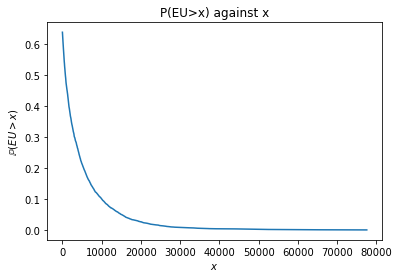

In [19]:
import math
import matplotlib.pyplot as plt

x=EUdis
ProbofnoEU=0
for i in range(len(EUdis)):
    if(EUdis[i]==0):
        ProbofnoEU+=1
ProbofnoEU=ProbofnoEU/len(EUdis)

print('The probability of no shortfall is:', ProbofnoEU )

P=[0]*len(EUdis)
for i in range(len(EUdis)):
    if EUdis[i]==0:
        P[i]= 1-ProbofnoEU
    else:
        P[i]= 1/len(EUdis)*(len(EUdis)-i)


plt.plot(x,P)
plt.title('P(EU>x) against x')
plt.xlabel('$x$')
plt.ylabel('$\mathbb{P}(EU>x)$')
plt.show()

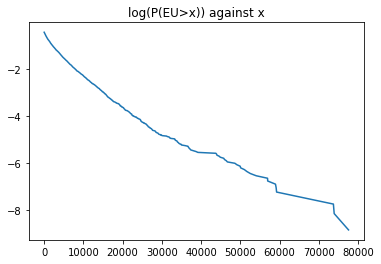

In [20]:
x=EUdis
logP=[0]*len(EUdis)
for i in range(len(EUdis)):
    if EUdis[i]==0:
        logP[i]= math.log(1-ProbofnoEU)
    else:
        logP[i]=math.log(1/len(EUdis)*(len(EUdis)-i))
    
plt.plot(x,logP)
plt.title('log(P(EU>x)) against x')
plt.show()

In [21]:
n=round(0.99*len(EUdis))
print(EUdis[n])

27587.734050753097


# Value at risk and CVaR




p value :  [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]

VaR :   [27587.734050753097, 15060.921576576395, 10017.704191320387, 7171.369234234095, 5395.032048768895, 4144.876378840396, 3049.854363786595, 2270.374049861195, 1652.6270376616958, 1190.385292005194, 748.6586418295992, 429.56274774769554, 184.7391891892039, 0, 0, 0, 0, 0, 0, 0, 0]

CVaR :  [40385.2863925531, 23716.72255940067, 17958.67558794927, 14780.95588718283, 12639.663928966653, 11052.52804160129, 9813.685139488236, 8792.85422318461, 7938.596650455845, 7215.532499924388, 6588.152191094955, 6042.391754520955, 5564.242267876974, 5141.5402633942185, 4774.287387437489, 4456.001561608323, 4177.5014640078025, 3931.7660837720496, 3713.3346346736025, 3517.8959696907814, 3342.0011712062424]


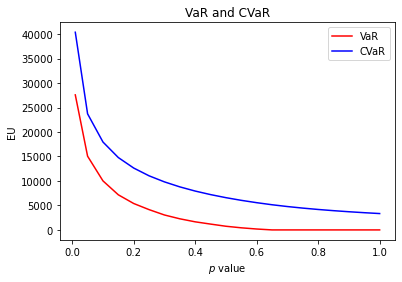

In [22]:
#VaR
x=[0.01]
for i in range(1,21):
    x.append(5*i/100)
#x=[0.01,0.05,0.10,...,1]

VaR=[]
CVaR=[]
for k in x:
    VaR.append(EUdis[int((1-k)*len(EUdis))])
    sum=0
    for j in range(int(k*len(EUdis))):
        sum+=EUdis[len(EUdis)-j-1]
    CVaR.append(sum/int(k*len(EUdis)))

# for k in x:
#     VaR.append(EUdis[int((k)*len(EUdis))-1])
#     sum=0
#     for j in range(int(k*len(EUdis))):
#         sum+=EUdis[j]
#     CVaR.append(sum/int(k*len(EUdis)))

print('p value : ', x)
print('')
print('VaR :  ', VaR)
print('')
print('CVaR : ', CVaR)


plt.plot(x,VaR,"r",label='VaR')
plt.plot(x,CVaR,"b",label='CVaR')
plt.title('VaR and CVaR')
plt.xlabel('$p$ value')
plt.ylabel('EU')
plt.legend()
plt.show()

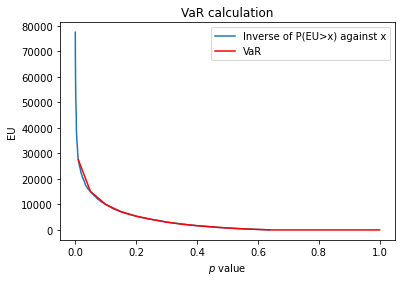

In [23]:
#for checking
#inverse of P(EU>x) against x

plt.plot(P,EUdis,label='Inverse of P(EU>x) against x')
plt.plot(x,VaR,"r",label='VaR')
plt.title('VaR calculation')
plt.xlabel('$p$ value')
plt.ylabel('EU')
plt.legend()
plt.show()

# b. Simulate data for One Year


This part is used to simulate data for one historical year. Run this part of the code "b" instead of "a" would generate the simulated data for one year instead of the 7 years.

In [24]:
# # Simulate One year data

# model3 = td_model(demand=demand_sepyear[0],renewables=wind_sepyear[0],gen_dists=td_convgen_dists)
# n_sim=10000
# sim_data_oneyear = model3.simulate_post_itc(n_sim=n_sim,c=0,policy="veto")

In [25]:
# # Simulate One year data EFC:
# EFC=3050
# EFCdem=demand_sepyear[0]-EFC
# EFCwind=np.zeros(shape=(3360,2))

# model2 = td_model(demand=EFCdem,renewables=EFCwind,gen_dists=td_convgen_dists)

# #use 1000,2000,3000,5000,10000
# n_sim=10000
# sim_data_EFC = model2.simulate_post_itc(n_sim=n_sim,c=0,policy="veto")

# b. EU distribution for one year


In [26]:
# # EUdis using wind generations

# EU=[0]*n_sim
# for i in range(n_sim):
#     tempEU=0
#     for j in range(3360):
#         tempEU+= -min(0,sim_data_oneyear[3360*i+j][0])
#     EU[i]=tempEU

# EUdis=sorted(EU)
# #print(EUdis)

In [27]:
# # EUdis_EFC using EFC
# EU_EFC=[0]*n_sim
# for i in range(n_sim):
#     tempEU=0
#     for j in range(3360):
#         tempEU+= -min(0,sim_data_EFC[3360*i+j][0])
#     EU_EFC[i]=tempEU


# EUdis_EFC=sorted(EU_EFC)